### 28.04.25, © Dmytro Sokhin KI-21-1, 2025

Source: https://github.com/https-deeplearning-ai/tensorflow-1-public

# Workshop 4 Assignment 1: Transfer Learning

Welcome to this assignment! This week, you are going to use a technique called `Transfer Learning` in which you utilize an already trained network to help you solve a similar problem to the one it was originally trained to solve.

Let's get started!

_**NOTE:** To prevent errors from the autograder, please avoid editing or deleting non-graded cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and refrain from adding any new cells._

In [20]:
# grader-required-cell

import os
import zipfile
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import urllib3
from tqdm.notebook import tqdm
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

## Dataset

For this assignment, you will use the `Horse or Human dataset`, which contains images of horses and humans. 

Download the `training` and `validation` sets by running the cell below:

In [6]:
def download_file(url, save_path):
    print(f"Attempting to download {os.path.basename(save_path)} from {url}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status() 

        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024

        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=os.path.basename(save_path))
        with open(save_path, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()

        if total_size != 0 and progress_bar.n != total_size:
            print(f"ERROR: Download size mismatch for {os.path.basename(save_path)}")
            return False
        else:
            print(f"Download completed: {save_path}")
            return True

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {os.path.basename(save_path)}: {e}")
        return False
    except Exception as e:
        print(f"An unexpected error occurred during download: {e}")
        return False

def extract_zip(zip_path, extract_to_dir):
    print(f"Attempting to extract {zip_path} to {extract_to_dir}...")
    os.makedirs(extract_to_dir, exist_ok=True)
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_dir)
        print(f"Successfully extracted {zip_path}")
        return True
    except zipfile.BadZipFile:
        print(f"ERROR: Failed to unzip {zip_path}. File might be corrupted.")
        return False
    except FileNotFoundError:
         print(f"ERROR: Cannot extract, zip file not found at {zip_path}")
         return False
    except Exception as e:
        print(f"An error occurred during extraction: {e}")
        return False

train_zip_save_path = './horse-or-human.zip'
val_zip_save_path = './validation-horse-or-human.zip'

train_extract_path = './tmp/training'
val_extract_path = './tmp/validation'

train_url = 'https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip'
val_url = 'https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip'

train_downloaded = download_file(train_url, train_zip_save_path)

val_downloaded = download_file(val_url, val_zip_save_path)

if train_downloaded:
    extract_zip(train_zip_save_path, train_extract_path)

if val_downloaded:
    extract_zip(val_zip_save_path, val_extract_path)

print("\nScript finished.")

Attempting to download horse-or-human.zip from https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip...


horse-or-human.zip:   0%|          | 0.00/150M [00:00<?, ?iB/s]

Download completed: ./horse-or-human.zip
Attempting to download validation-horse-or-human.zip from https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip...


validation-horse-or-human.zip:   0%|          | 0.00/11.5M [00:00<?, ?iB/s]

Download completed: ./validation-horse-or-human.zip
Attempting to extract ./horse-or-human.zip to ./tmp/training...
Successfully extracted ./horse-or-human.zip
Attempting to extract ./validation-horse-or-human.zip to ./tmp/validation...
Successfully extracted ./validation-horse-or-human.zip

Script finished.


This dataset already has an structure that is compatible with Keras' `flow_from_directory` so you don't need to move the images into subdirectories as you did in the previous assignments. However, it is still a good idea to save the paths of the images so you can use them later on:

In [8]:
# grader-required-cell

# Define the training and validation base directories
train_dir = './tmp/training'
validation_dir = './tmp/validation'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')    
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



Now take a look at a sample image of each one of the classes:

Sample horse image:


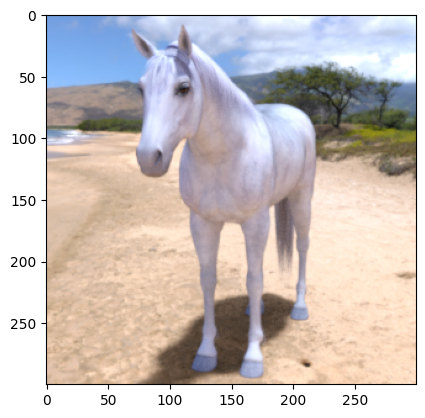


Sample human image:


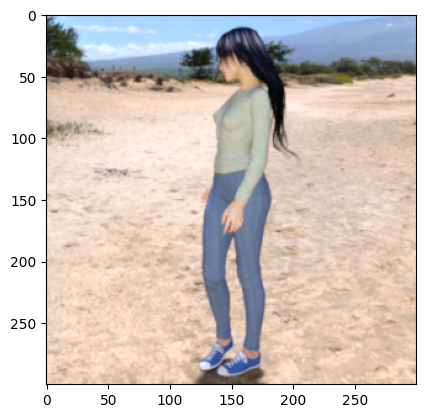

In [9]:
# grader-required-cell

print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

`matplotlib` makes it easy to see that these images have a resolution of 300x300 and are colored, but you can double check this by using the code below:

In [10]:
# grader-required-cell

# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


As expected, the sample image has a resolution of 300x300 and the last dimension is used for each one of the RGB channels to represent color.

## Training and Validation Generators

Now that you know the images you are dealing with, it is time for you to code the generators that will fed these images to your Network. For this, complete the `train_val_generators` function below:

**Important Note:** The images have a resolution of 300x300 but the `flow_from_directory` method you will use allows you to set a target resolution. In this case, **set a `target_size` of (150, 150)**. This will heavily lower the number of trainable parameters in your final network, yielding much quicker training times without compromising the accuracy!

In [13]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator: tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class for training data
  # Normalize pixel values by rescaling
  # Note: No augmentation is applied here as per previous assignment instructions,
  #       but the prompt mentions it. Sticking to rescale-only for now.
  #       If augmentation WAS required, you'd add parameters like:
  #       rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
  #       shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
  train_datagen = ImageDataGenerator(rescale = 1./255) # Тільки нормалізація

  # Pass in the appropriate arguments to the flow_from_directory method for the training generator
  train_generator = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,       # Directory for training images
      batch_size=32,                # Set batch size to 32
      class_mode='binary',          # Since we use binary_crossentropy loss, we need binary labels (0 or 1)
      target_size=(150, 150)        # Resize all images to 150x150 as requested
  )

  # Instantiate the ImageDataGenerator class for validation data
  # Remember that validation data should not be augmented, only rescaled
  validation_datagen = ImageDataGenerator(rescale = 1./255) # Тільки нормалізація

  # Pass in the appropriate arguments to the flow_from_directory method for the validation generator
  validation_generator = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,     # Directory for validation images
      batch_size=32,                # Set batch size to 32
      class_mode='binary',          # Need binary labels
      target_size=(150, 150)        # Must match the target size of the training generator
  )
  ### END CODE HERE
  return train_generator, validation_generator

In [14]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


**Expected Output:**
```
Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
```

## Transfer learning - Create the pre-trained model

Download the `inception V3` weights into the `/tmp/` directory:

In [ ]:
import requests
import os
from tqdm.notebook import tqdm 
import urllib3 

url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

save_dir = "./tmp/"

filename = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

save_path = os.path.join(save_dir, filename)

try:
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    print("InsecureRequestWarning disabled.")
except AttributeError:
    print("Could not disable InsecureRequestWarning (urllib3 might be older or not installed).")

try:
    os.makedirs(save_dir, exist_ok=True)
    print(f"Directory '{save_dir}' ensured to exist.")
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
print(f"Attempting to download weights from: {url}")
print(f"Saving to: {os.path.abspath(save_path)}")

try:
    response = requests.get(url, stream=True, verify=False)

    response.raise_for_status()

    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024 * 1024

    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=filename)

    with open(save_path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data)) 
            file.write(data)

    progress_bar.close() 

    if total_size != 0 and progress_bar.n != total_size:
        print("ERROR: Download size mismatch!")
    else:
        print(f"\nDownload completed successfully: {save_path}")

except requests.exceptions.RequestException as e:
    print(f"\nError during download: {e}")
except IOError as e:
    print(f"\nError writing file {save_path}: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

InsecureRequestWarning disabled.
Directory './tmp/' ensured to exist.
Attempting to download weights from: https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Saving to: c:\Users\user\Downloads\Workshop\tmp\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5:   0%|          | 0.00/87.9M [00:00<?, ?iB/s]


Download completed successfully: ./tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


Now load the `InceptionV3` model and save the path to the weights you just downloaded:

In [22]:
# grader-required-cell

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = './tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

Complete the `create_pre_trained_model` function below. You should specify the correct `input_shape` for the model (remember that you set a new resolution for the images instead of the native 300x300) and make all of the layers non-trainable:

In [23]:
# grader-required-cell

# GRADED FUNCTION: create_pre_trained_model
def create_pre_trained_model(local_weights_file):
  """
  Initializes an InceptionV3 model.
  
  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file
    
  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """
  ### START CODE HERE

  # Initialize the InceptionV3 model.
  # Set the input shape to the target size used in the generators (150x150) with 3 color channels.
  # include_top=False to exclude the final classification layer.
  # weights=None because we will load weights manually from the local file.
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                  include_top = False,       
                                  weights = None)          

  # Load the pre-trained weights from the specified file
  if os.path.exists(local_weights_file):
      print(f"Loading weights from {local_weights_file}...")
      pre_trained_model.load_weights(local_weights_file)
      print("Weights loaded successfully.")
  else:
      print(f"ERROR: Weights file not found at {local_weights_file}")
      return None

  # Make all the layers in the pre-trained model non-trainable (freeze them)
  for layer in pre_trained_model.layers:
    layer.trainable = False

  print("All layers in the pre-trained model have been frozen.")

  ### END CODE HERE

  return pre_trained_model

Check that everything went well by comparing the last few rows of the model summary to the expected output:

In [24]:
# grader-required-cell

pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Loading weights from ./tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5...
Weights loaded successfully.
All layers in the pre-trained model have been frozen.


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

**Expected Output:**
```
batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
__________________________________________________________________________________________________
activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
__________________________________________________________________________________________________
mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
                                                                activation_276[0][0]             
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
                                                                activation_280[0][0]             
__________________________________________________________________________________________________
activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
__________________________________________________________________________________________________
mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
                                                                mixed9_1[0][0]                   
                                                                concatenate_5[0][0]              
                                                                activation_281[0][0]             
==================================================================================================
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784


```

To check that all the layers in the model were set to be non-trainable, you can also run the cell below:

In [25]:
# grader-required-cell

total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


**Expected Output:**
```
There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.
```

## Creating callbacks for later

You have already worked with callbacks in the first course of this specialization so the callback to stop training once an accuracy of 99.9% is reached, is provided for you:

In [26]:
# grader-required-cell

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

## Pipelining the pre-trained model with your own

Now that the pre-trained model is ready, you need to "glue" it to your own model to solve the task at hand.

For this you will need the last output of the pre-trained model, since this will be the input for your own. Complete the `output_of_last_layer` function below.

**Note:** For grading purposes use the `mixed7` layer as the last layer of the pre-trained model. However, after submitting feel free to come back here and play around with this.

In [ ]:
import tensorflow as tf

def output_of_last_layer(pre_trained_model):
  """
  Gets the output of the 'mixed7' layer from the pre-trained model.
  """
  last_output = None 

  if not isinstance(pre_trained_model, tf.keras.Model):
      print("Error: Invalid pre_trained_model provided.")
      return None

  target_layer_name = 'mixed7'

  try:
      last_desired_layer = pre_trained_model.get_layer(target_layer_name)

      last_output = last_desired_layer.output

      print(f'Successfully retrieved output tensor from layer: {target_layer_name}')
      print(f'Shape of {target_layer_name} output: {last_output.shape}')
      print(f'Output tensor: {last_output}')

  except ValueError:
      print(f"Error: Layer '{target_layer_name}' not found in the pre_trained_model.")
  except AttributeError as e:
      print(f"Error retrieving output from layer '{target_layer_name}': {e}")
      print(f"Check if '{target_layer_name}' is the correct layer to get output from. Layer type: {type(last_desired_layer)}")
  except Exception as e:
      print(f"An unexpected error occurred while getting output from layer '{target_layer_name}': {e}")

  return last_output 

Check that everything works as expected:

In [37]:
# grader-required-cell

last_output = output_of_last_layer(pre_trained_model)

Successfully retrieved output tensor from layer: mixed7
Shape of mixed7 output: (None, 7, 7, 768)
Output tensor: <KerasTensor shape=(None, 7, 7, 768), dtype=float32, sparse=False, ragged=False, name=keras_tensor_228>


**Expected Output (if `mixed7` layer was used):**
```
last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")
```

Now you will create the final model by adding some additional layers on top of the pre-trained model.

Complete the `create_final_model` function below. You will need to use Tensorflow's [Functional API](https://www.tensorflow.org/guide/keras/functional) for this since the pretrained model has been created using it. 

Let's double check this first:

In [38]:
# grader-required-cell

# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.models.functional.Functional'>


To create the final model, you will use Keras' Model class by defining the appropriate inputs and outputs as described in the first way to instantiate a Model in the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

Note that you can get the input from any existing model by using its `input` attribute and by using the Funcional API you can use the last layer directly as output when creating the final model.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model # Важливо імпортувати Model
from tensorflow.keras.optimizers import RMSprop # Імпортуємо оптимізатор

# grader-required-cell

# GRADED FUNCTION: create_final_model
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom classification head to a pre-trained model.
  
  Args:
    pre_trained_model (tf.keras.Model): The pre-trained base model (e.g., InceptionV3). 
                                       Its layers should ideally be frozen.
    last_output (tf.Tensor): The symbolic output tensor from the desired layer
                             of the pre_trained_model (e.g., output of 'mixed7').
    
  Returns:
    tf.keras.Model: The combined model ready for training.
                    Returns None if inputs are invalid.
  """
  if not isinstance(pre_trained_model, tf.keras.Model):
      print("Error: pre_trained_model is not a valid Keras Model.")
      return None
  
  if last_output is None:
      print("Error: last_output provided is None.")
      return None

  # Flatten the output layer of the pre-trained model to 1 dimension
  x = layers.Flatten()(last_output)

  ### START CODE HERE

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)

  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)

  # Add a final sigmoid layer for classification (1 neuron for binary classification)
  x = layers.Dense(1, activation='sigmoid')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer=RMSprop(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  ### END CODE HERE

  return model

In [ ]:
# Перед викликом create_final_model
print(f"Type of pre_trained_model: {type(pre_trained_model)}")
print(f"Is pre_trained_model None? {pre_trained_model is None}")
print(f"Type of last_output: {type(last_output)}")
print(f"Is last_output None? {last_output is None}")

# grader-required-cell
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

print(f"Type of model after creation: {type(model)}")
print(f"Is model None? {model is None}")

if model is not None:
    # Inspect parameters
    total_params = model.count_params()
    num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

    print(f"There are {total_params:,} total parameters in this model.")
    print(f"There are {num_trainable_params:,} trainable parameters in this model.")
else:
    print("Model creation failed, cannot count parameters.")

Type of pre_trained_model: <class 'keras.src.models.functional.Functional'>
Is pre_trained_model None? False
Type of last_output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Is last_output None? False
Type of model after creation: <class 'keras.src.models.functional.Functional'>
Is model None? False
There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


**Expected Output:**
```
There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.
```

Wow, that is a lot of parameters!

After submitting your assignment later, try re-running this notebook but use the original resolution of 300x300, you will be surprised to see how many more parameters are for that case.

Now train the model:

In [47]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take a few epochs)
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
33/33 - 103s - 3s/step - accuracy: 0.9630 - loss: 0.0845 - val_accuracy: 0.9961 - val_loss: 0.0137
Epoch 2/100

Reached 99.9% accuracy so cancelling training!
33/33 - 123s - 4s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0091


The training should have stopped after less than 10 epochs and it should have reached an accuracy over 99,9% (firing the callback). This happened so quickly because of the pre-trained model you used, which already contained information to classify humans from horses. Really cool!

Now take a quick look at the training and validation accuracies for each epoch of training:

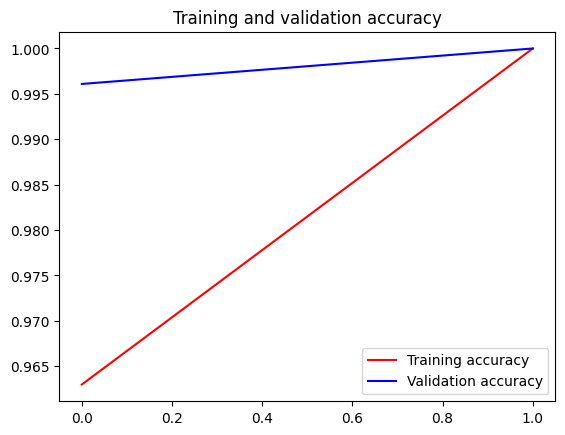

<Figure size 640x480 with 0 Axes>

In [48]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()